# Creating simple Keras model for inference on microcontollers

## Mount Google Drive

In [0]:
from google.colab import drive
import sys

# Mount gdrive
drive.mount('/gdrive')

# Check path, see if python notebook is inside correct folder
%cd /gdrive/My\ Drive/Colab\ Notebooks/ML_tensorflow_article
%ls

# Append location of our folder to python sys path
sys.path.append('/gdrive/My\ Drive/Colab\ Notebooks/ML_tensorflow_article')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/Colab Notebooks/ML_tensorflow_article
cifar_model.h5           cifar_quant_dynamic_size.tflite
cifar_no_quant.tflite    cifar_quant_dynamic.tflite
cifar_quant16.tflite     keras_model_to_tflite.ipynb
cifar_quant_8bit.tflite  pictures/


## Setup


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Download dataset


In [0]:
# Load CIFAR10 dataset, we can use Tensorflow for this
train_dataset, test_dataset = tf.keras.datasets.cifar10.load_data()

print("Number of pictures in train dataset: {}".format(train_dataset[0].shape[0]))
print("Number of pictures in test dataset: {}".format(test_dataset[0].shape[0]))
print("Picture resolution: {} x {}".format(train_dataset[0].shape[1], train_dataset[0].shape[2]))
print("Number of color channels: {}".format(train_dataset[0].shape[3]))
print("Shape of train labels: {}".format(train_dataset[1].shape))

170500096/170498071 [==============================] - 4s 0us/step
Number of pictures in train dataset: 50000
Number of pictures in test dataset: 10000
Picture resolution: 32 x 32
Number of color channels: 3
Shape of train labels: (50000, 1)


# Create validation set


In [0]:
num_training=49000
num_validation=1000
num_test=1000

# Separate labels from pictures
X_train_whole = train_dataset[0]
y_train_whole = train_dataset[1]
X_test_whole = test_dataset[0]
y_test_whole = test_dataset[1]


mask = list(range(num_training, num_training + num_validation))
X_val_rgb = X_train_whole[mask]
y_val = y_train_whole[mask]

mask = list(range(num_training))
X_train_rgb = X_train_whole[mask]
y_train = y_train_whole[mask]

mask = list(range(num_test))
X_test_rgb = X_test_whole[mask]
y_test = y_test_whole[mask]

# Print shapes
print('Train data shape:        ', X_train_rgb.shape)
print('Train labels shape:      ', y_train.shape)
print('Validation data shape:   ', X_val_rgb.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape:         ', X_test_rgb.shape)
print('Test labels shape:       ', y_test.shape)

Train data shape:         (49000, 32, 32, 3)
Train labels shape:       (49000, 1)
Validation data shape:    (1000, 32, 32, 3)
Validation labels shape:  (1000, 1)
Test data shape:          (1000, 32, 32, 3)
Test labels shape:        (1000, 1)


# Visualize pictures

Let's see what kind of pictures are inside CIFAR-10 dataset.


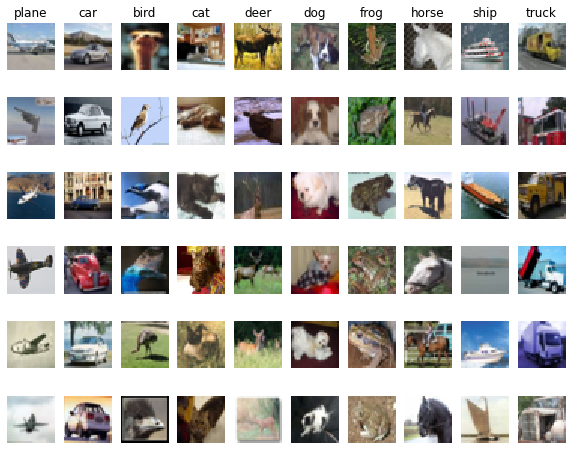

In [0]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 6
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train_rgb[idx])
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

# Colorful into grayscale

We can scale each color with some factor and add them up to create greyscale image. There are several ways to do that, I chose linear approximation of gamma-compression-corrected version.
 
Equation that we will use is:
$$Y' = 0.299R' + 0.587G' + 0.114B'$$

You can read up more on this interesting website: https://brohrer.github.io/convert_rgb_to_grayscale.html 



Train data shape:         (49000, 32, 32, 1)
Train labels shape:       (49000, 1)
Validation data shape:    (1000, 32, 32, 1)
Validation labels shape:  (1000, 1)
Test data shape:          (1000, 32, 32, 1)
Test labels shape:        (1000, 1)


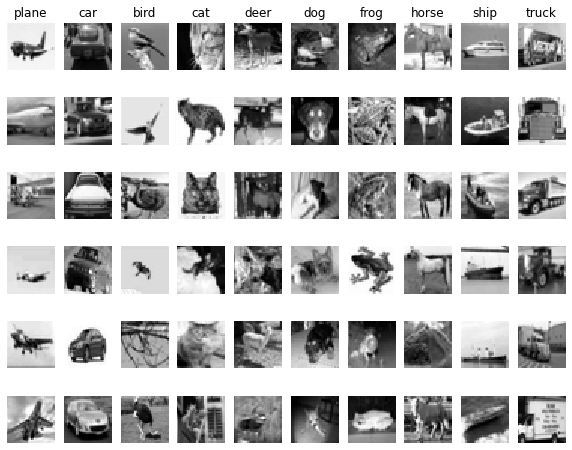

In [0]:
def rgb2gray(rgb):
  rgb[...,0] = rgb[...,0] * 0.2989  # Red channel
  rgb[...,1] = rgb[...,1] * 0.5870  # Green channel
  rgb[...,2] = rgb[...,2] * 0.1140  # Blue channel

  # We want to keep dimensions same so that we go from
  # (49000, 32, 32 ,3) to (49000, 32, 32, 1) and not to (49000, 32, 32)
  return np.around(np.sum(rgb, axis=3, keepdims=True)) 
   

# Convert all data into grayscale and drop decimal part
X_train = rgb2gray(X_train_rgb)
X_val = rgb2gray(X_val_rgb)
X_test = rgb2gray(X_test_rgb)


# Print out shapes to see the change
print('Train data shape:        ', X_train.shape)
print('Train labels shape:      ', y_train.shape)
print('Validation data shape:   ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape:         ', X_test.shape)
print('Test labels shape:       ', y_test.shape)


# Lets also visualize again to see the change
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 6
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].reshape((32, 32)).astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

## Extract 3 classes
Images are now grayscaled, before doing mean normalization we should get out only few categories that we actually want to train on. Lets extract 3 classes: cats, dogs and frogs.

Train data shape:         (14688, 32, 32, 1)
Train labels shape:       (14688, 1)
Validation data shape:    (312, 32, 32, 1)
Validation labels shape:  (312, 1)
Test data shape:          (301, 32, 32, 1)
Test labels shape:        (301, 1)


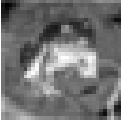

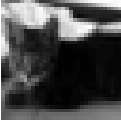

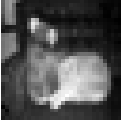

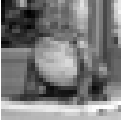

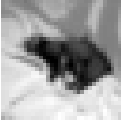

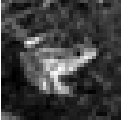

In [0]:
# Position of correct classes, cat will be marked as 3, dog as 5, frog as 6
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Extract 3 classes
mask = (y_train == 3) | (y_train == 5) | (y_train == 6)
mask = mask.reshape(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

mask = (y_val == 3) | (y_val == 5) | (y_val == 6)
mask = mask.reshape(num_validation)
X_val = X_val[mask]
y_val = y_val[mask]

mask = (y_test == 3) | (y_test == 5) | (y_test == 6)
mask = mask.reshape(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

# We adjust labels of the classes to be 0,1,2 and not 3,5,6
def adjust_classes(y):
  '''
  We want labels to be 0,1,2 so we will subtract from existing ones
  '''
  y[y == 3] -= 3
  y[y == 5] -= 4
  y[y == 6] -= 4

adjust_classes(y_train)
adjust_classes(y_val)
adjust_classes(y_test)


# Print out shapes to see the change
print('Train data shape:        ', X_train.shape)
print('Train labels shape:      ', y_train.shape)
print('Validation data shape:   ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape:         ', X_test.shape)
print('Test labels shape:       ', y_test.shape)

# Check first few images, we are expecting only cats, dogs and frogs
def show_single_image(image, dpi=5):
  plt.figure(figsize=(32, 32),dpi=dpi)
  plt.subplot(1, 1, 1)
  plt.imshow(image.reshape((32, 32)).astype('uint8'))
  plt.axis('off')
  plt.show()

for i in range(6):
  show_single_image(X_train[i])


## Preprocessing

Mean subtraction is the most common form of preprocessing. It involves subtracting the mean across every individual feature in the data, and has the geometric interpretation of centering the cloud of data around the origin along every dimension. This prevents gradients to be either positive or negative, which would their values harder to converge. Many algorithms show better performances when the dataset is symmetric (with a zero-mean).

Another preprocessing technique is normalization which squizes input values between -1 and 1. This is used when input values are widly different which in case of pixels where values range from 0 to 255 (before mean substracion) is not really necessary.

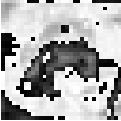

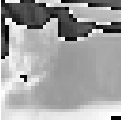

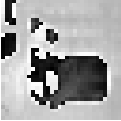

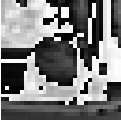

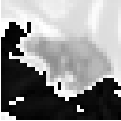

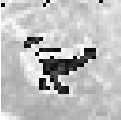

In [0]:
# Normalize the data: subtract the mean image
mean_image = np.around(np.mean(X_train, axis=0))
X_train = X_train - mean_image
X_val = X_val - mean_image
X_test = X_test - mean_image

# It is interesting to see how pictures changed
for i in range(6):
  show_single_image(X_train[i])

## Creating Keras model


In [0]:
from tensorflow.keras import datasets, layers, models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))

# Show the model's architecture
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                6

In [0]:
# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [0]:
# Train the model, this will take some time
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val))



Epoch 1/20
459/459 [==============================] - 3s 6ms/step - loss: 0.9680 - accuracy: 0.5598 - val_loss: 0.8304 - val_accuracy: 0.5801
Epoch 2/20
459/459 [==============================] - 3s 6ms/step - loss: 0.7593 - accuracy: 0.6393 - val_loss: 0.7494 - val_accuracy: 0.6378
Epoch 3/20
459/459 [==============================] - 3s 6ms/step - loss: 0.7075 - accuracy: 0.6681 - val_loss: 0.7115 - val_accuracy: 0.6538
Epoch 4/20
459/459 [==============================] - 3s 6ms/step - loss: 0.6543 - accuracy: 0.7032 - val_loss: 0.7839 - val_accuracy: 0.6090
Epoch 5/20
459/459 [==============================] - 3s 6ms/step - loss: 0.6137 - accuracy: 0.7261 - val_loss: 0.7573 - val_accuracy: 0.6474
Epoch 6/20
459/459 [==============================] - 3s 6ms/step - loss: 0.5634 - accuracy: 0.7529 - val_loss: 0.6805 - val_accuracy: 0.6667
Epoch 7/20
459/459 [==============================] - 3s 6ms/step - loss: 0.5221 - accuracy: 0.7721 - val_loss: 0.7698 - val_accuracy: 0.6859
Epoch 

## Evaluate accuracy


10/10 - 0s - loss: 1.4917 - accuracy: 0.7209


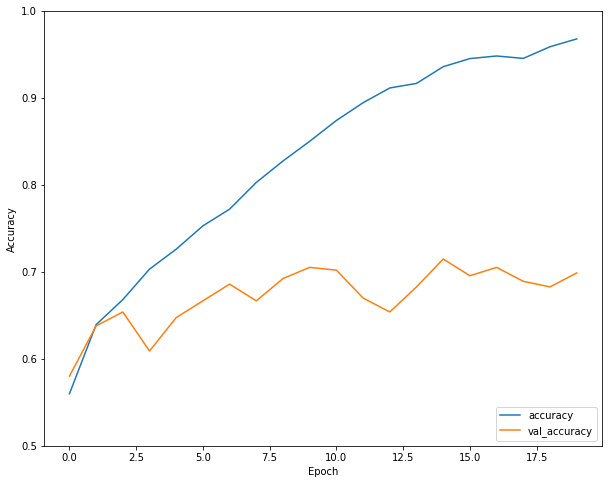

In [0]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

## Converting the model and quantization


In [0]:
# Save the entire model to a HDF5 file.
model.save('cifar_model.h5') 

We can easily load that model (or any other) back.

In [0]:
import os

# Recreate the exact same model, including its weights and the optimizer
model = tf.keras.models.load_model('cifar_model.h5')

# Show the model architecture
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                6

In [0]:
# Convert the model without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model to disk
open("cifar_no_quant.tflite", "wb").write(tflite_model)

# Show size of the model
h5_in_kb = os.path.getsize("cifar_model.h5") / 1024
print("Size of h5 model: {} KB".format(h5_in_kb))

# Show size of the model
tflite_in_kb = os.path.getsize("cifar_no_quant.tflite") / 1024
print("Size of tflite model: {} KB".format(tflite_in_kb))

print("Decreased for factor: {}".format(h5_in_kb/tflite_in_kb))

Size of h5 model: 1472.515625 KB
Size of tflite model: 477.34375 KB
Decreased for factor: 3.08481178396072


In [0]:
# Convert the model to the TensorFlow Lite format with float16 quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
tflite_model = converter.convert()
# Save to disk
open("cifar_quant16.tflite", "wb").write(tflite_model)

# Convert the model to the TensorFlow Lite format with dynamic range quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()
# Save to disk
open("cifar_quant_dynamic.tflite", "wb").write(tflite_model)

# Convert the model to the TensorFlow Lite format with full intiger quantization

# For this quantization we need to create representative dataset
images = tf.cast(X_test, tf.float32)
cifar_data = tf.data.Dataset.from_tensor_slices(images).batch(1)
def representative_dataset_gen():
  for input in cifar_data.take(100):
    # Get sample input data as a numpy array in a method of your choosing.
    yield [input]

converter = tf.compat.v1.lite.TFLiteConverter.from_keras_model_file("cifar_model.h5")
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.float32
tflite_model = converter.convert()
# Save to disk
open("cifar_quant_8bit.tflite", "wb").write(tflite_model)

# Show size of the model
tflite_in_kb = os.path.getsize("cifar_no_quant.tflite") / 1024
print("Size of no quant model:            {} KB".format(tflite_in_kb))

# Show sizes of the models
tflite_in_kb = os.path.getsize("cifar_quant16.tflite") / 1024
print("Size of quant16 model:             {} KB".format(tflite_in_kb))

tflite_in_kb = os.path.getsize("cifar_quant_dynamic.tflite") / 1024
print("Size of quant dynamic model:       {} KB".format(tflite_in_kb))

tflite_in_kb = os.path.getsize("cifar_quant_8bit.tflite") / 1024
print("Size of quant 8 bit model:         {} KB".format(tflite_in_kb))

Size of no quant model:            477.34375 KB
Size of quant16 model:             241.0859375 KB
Size of quant dynamic model:       123.4765625 KB
Size of quant 8 bit model:         128.1875 KB


## Write model to C file 


In [0]:
# Install xxd if it is not available
!apt-get -qq install xxd

# Save the file as a C source file
!xxd -i cifar_quant_8bit.tflite > cifar_model.cc

# Print the head and tail of model c file
!cat cifar_model.cc | (head; echo; tail)

unsigned char cifar_quant_8bit_tflite[] = {
  0x08, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x9a, 0x20, 0xfe, 0xff,
  0x03, 0x00, 0x00, 0x00, 0x34, 0x00, 0x02, 0x00, 0x50, 0xdf, 0x01, 0x00,
  0x38, 0xdf, 0x01, 0x00, 0x04, 0x00, 0x00, 0x00, 0x16, 0x00, 0x00, 0x00,
  0x28, 0xdf, 0x01, 0x00, 0x14, 0xdf, 0x01, 0x00, 0xf8, 0xdd, 0x01, 0x00,
  0xd4, 0xdd, 0x01, 0x00, 0xb0, 0xdd, 0x01, 0x00, 0x9c, 0xdd, 0x00, 0x00,
  0xc8, 0xdc, 0x00, 0x00, 0x94, 0xdb, 0x00, 0x00, 0x80, 0x93, 0x00, 0x00,
  0x6c, 0x03, 0x00, 0x00, 0xd8, 0x02, 0x00, 0x00, 0xc4, 0x01, 0x00, 0x00,
  0xb0, 0x00, 0x00, 0x00, 0xa4, 0x00, 0x00, 0x00, 0x90, 0x00, 0x00, 0x00,
  0x7c, 0x00, 0x00, 0x00, 0x68, 0x00, 0x00, 0x00, 0x54, 0x00, 0x00, 0x00,

  0x00, 0x00, 0x00, 0x06, 0x02, 0x00, 0x00, 0x00, 0xc2, 0xff, 0xff, 0xff,
  0x00, 0x00, 0x00, 0x19, 0x02, 0x00, 0x00, 0x00, 0xe6, 0xff, 0xff, 0xff,
  0x00, 0x00, 0x00, 0x09, 0x04, 0x00, 0x00, 0x00, 0x00, 0x00, 0x06, 0x00,
  0x06, 0x00, 0x05, 0x00, 0x06, 0x00, 0x00, 0x00, 0x00, 0x16, 0x0a,

## Write pictures to C file


In [0]:
# First we have to reshape them from (32,32,1) to (32,32).
# Second we need to ensure that they are certain data width, that is 8 bits.
# With tofile method we save them into temporary text file as binary data,
# which we will feed into xxd tool to create C file.

def save_binary(image, filename):
  image.reshape(32,32).astype(np.int8).tofile("temp.txt")
  !xxd -i temp.txt > {filename}
  !rm temp.txt

save_binary(X_test[0], "picture0.cc")
save_binary(X_test[1], "picture1.cc")
save_binary(X_test[2], "picture2.cc")
save_binary(X_test[3], "picture3.cc")
save_binary(X_test[4], "picture4.cc")
save_binary(X_test[5], "picture5.cc")

## Testing model with python interpreter



In [0]:
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="cifar_quant_8bit.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()


# Print some details about input and output
print("Shape of input:      ", input_details[0]['shape'])
print("Data type of input:  ", input_details[0]['dtype'])
print("Shape of output:     ", output_details[0]['shape'])
print("Data type of output: ", output_details[0]['dtype'])


Shape of input:       [ 1 32 32  1]
Data type of input:   <class 'numpy.int8'>
Shape of output:      [1 3]
Data type of output:  <class 'numpy.float32'>


In [0]:

def invoke(X_test):
  input_data = tf.cast(np.array(X_test), tf.int8)
  input_data = np.expand_dims(input_data, axis=0)
  interpreter.set_tensor(input_details[0]['index'], input_data)
  interpreter.invoke()
  output_data = interpreter.get_tensor(output_details[0]['index'])
  print(output_data)

# Call invoke on first 6 pictures of test data
invoke(X_test[0])
invoke(X_test[1])
invoke(X_test[2])
invoke(X_test[3])
invoke(X_test[4])
invoke(X_test[5])

[[0.        0.9296875 0.0703125]]
[[0.         0.         0.99609375]]
[[0.         0.         0.99609375]]
[[0.         0.         0.99609375]]
[[0.99609375 0.00390625 0.        ]]
[[0.8125 0.1875 0.    ]]
